<a href="https://colab.research.google.com/github/OJB-Quantum/Qiskit-Metal-to-Litho/blob/main/Qiskit_Metal_Fully_in_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Headless preflight (Qt off) + deps
import os
os.environ["QT_QPA_PLATFORM"] = "offscreen"
os.environ["MPLBACKEND"] = "Agg"

import matplotlib as mpl
try:
    mpl.use("Agg", force=True)
except TypeError:
    mpl.use("Agg")
print("Matplotlib backend:", mpl.get_backend())

# Scientific + GDS toolchain (incl. Descartes)
!pip install "jedi>=0.16"
%pip -q install --upgrade pip wheel setuptools
%pip -q install "numpy>=1.24" "matplotlib>=3.8" \
                "gdstk>=0.9.61" "shapely>=2.0" "ezdxf>=1.2.0" \
                "pandas>=2.0" "scipy>=1.10" "networkx>=2.8" \
                "pint>=0.20" "addict>=2.4.0" "pyyaml>=6.0.1" \
                "qutip>=4.7" "h5py>=3.8" "descartes>=1.1" "jedi>=0.19.1"

Matplotlib backend: Agg
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.2 MB/s eta 0:00:00


In [2]:
#@title Clone Metal; bind to /content/qiskit-metal; headless, layout-only init (Dict + is_component)
# pylint: disable=invalid-name
import os, sys, re, textwrap
from pathlib import Path

# Fresh clone
!rm -rf /content/qiskit-metal
!git clone --depth 1 https://github.com/qiskit-community/qiskit-metal /content/qiskit-metal

root = Path("/content/qiskit-metal")
pkg  = root / "qiskit_metal"
assert pkg.exists(), f"Package folder missing: {pkg}"

# Force Python to import FROM THIS FOLDER (no editable install)
if str(root) not in sys.path:
    sys.path.insert(0, str(root))
os.environ["PYTHONPATH"] = str(root) + (":" + os.environ.get("PYTHONPATH",""))

# --- Replace qiskit_metal/__init__.py with a minimal but compatible headless init ---
orig_init = (pkg / "__init__.py").read_text(encoding="utf-8")
(pkg / "__init__orig.py").write_text(orig_init, encoding="utf-8")

minimal_init = textwrap.dedent("""
    # [colab] Headless, layout-only __init__ (no GUI, no analyses), keep essentials.
    import logging as _logging
    try:
        from addict import Dict as Dict
    except Exception:
        from .toolbox_python.attr_dict import Dict

    logger = _logging.getLogger("qiskit_metal_colab")

    class _Config:
        @staticmethod
        def is_building_docs():
            return False
    config = _Config()

    def is_design(obj):
        try:
            from .designs.design_base import QDesign
            return isinstance(obj, QDesign)
        except Exception:
            return False

    def is_component(obj):
        try:
            from .qlibrary.core.base import QComponent
            return isinstance(obj, QComponent)
        except Exception:
            return False

    __all__ = ["Dict", "config", "logger", "is_design", "is_component"]
""").strip()+"\n"
(pkg / "__init__.py").write_text(minimal_init, encoding="utf-8")

# --- Scrub ALL draw.mpl imports to avoid PySide2 at import time ---
draw_init = pkg / "draw" / "__init__.py"
if draw_init.exists():
    d = draw_init.read_text(encoding="utf-8")
    # Guard "from . import mpl"
    d = re.sub(r'^\s*from\s+\.\s*import\s+mpl\s*$',
               "try:\n    from . import mpl\n"
               "except Exception as _e:\n"
               "    print('[colab] draw.mpl disabled (headless):', _e)\n",
               d, flags=re.MULTILINE)
    # Guard "from .mpl import ..." and any other .mpl imports
    d = re.sub(r'^\s*from\s+\.\s*mpl\s+import[^\n]*$',
               "try:\n    from .mpl import render, figure_spawn\n"
               "except Exception as _e:\n"
               "    print('[colab] draw.mpl (named) disabled (headless):', _e)\n"
               "    def render(*a, **k):\n"
               "        raise RuntimeError('draw.mpl unavailable in headless mode')\n"
               "    def figure_spawn(*a, **k):\n"
               "        raise RuntimeError('draw.mpl unavailable in headless mode')\n",
               d, flags=re.MULTILINE)
    draw_init.write_text(d, encoding="utf-8")

# Optional: ensure renderers package never drags Qt; keep explicit imports only
rndr_init = pkg / "renderers" / "__init__.py"
if rndr_init.exists():
    (rndr_init.parent / "__init__orig.py").write_text(rndr_init.read_text(encoding="utf-8"), encoding="utf-8")
    rndr_init.write_text("# [colab] minimal renderers package (explicit imports only; no Qt/MPL)\n__all__ = []\n",
                         encoding="utf-8")

# Verify: import the package *from this folder* and keep it light
import importlib, sys as _sys
importlib.invalidate_caches()
import qiskit_metal
print("qiskit_metal from:", qiskit_metal.__file__)
assert qiskit_metal.__file__.startswith(str(pkg)), "Not importing from /content/qiskit-metal!"


Cloning into '/content/qiskit-metal'...
remote: Enumerating objects: 1050, done.
remote: Counting objects: 100% (1050/1050), done.
remote: Compressing objects: 100% (952/952), done.
remote: Total 1050 (delta 166), reused 672 (delta 88), pack-reused 0 (from 0)
Receiving objects: 100% (1050/1050), 30.22 MiB | 24.81 MiB/s, done.
Resolving deltas: 100% (166/166), done.
qiskit_metal from: /content/qiskit-metal/qiskit_metal/__init__.py


In [9]:
# --- Headless hygiene ---
import os, sys
os.environ["QT_QPA_PLATFORM"] = "offscreen"  # ensure Qt stays headless if present

# --- Design & defaults (kept from your snippet) ---
from pathlib import Path
from qiskit_metal.designs import DesignPlanar
from qiskit_metal.toolbox_python.attr_dict import Dict
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

# Your knobs (unchanged unless noted)
CPW_WIDTH_UM    = 10.0
CPW_GAP_UM      = 6.0
MEANDER_LEN_UM  = 3000.0    # total centerline length target for the meander section (excludes leads)
# Key change 1: make fillet modest so straight spans can exceed 2*fillet
FILLET_UM       = 60.0
MEANDER_SP_UM   = 700.0
# Key change 2: give the router enough straight lead length so near-pad jogs aren’t “short segments”
LEAD_START_UM   = 300.0
LEAD_END_UM     = 300.0

PAD_WIDTH_UM    = 300.0
TAPER_HEIGHT_UM = 300.0
PAD_HEIGHT_UM   = 240.0
PAD_GAP_UM      = 144.0
LEAD_LEN_UM     = 50.0

LP_LEFT_X_UM    = 0.0
LP_RIGHT_X_UM   = 4500.0
LP_Y_UM         = 0.0

# --- Build design headlessly ---
design = DesignPlanar(metadata={}, overwrite_enabled=True, enable_renderers=False)
design.variables["cpw_width"] = f"{CPW_WIDTH_UM}um"
design.variables["cpw_gap"]   = f"{CPW_GAP_UM}um"
design.chips.main.size["size_x"] = "8mm"
design.chips.main.size["size_y"] = "4mm"

lpL = LaunchpadWirebond(
    design, "LP_left",
    options=dict(
        pos_x=f"{LP_LEFT_X_UM}um", pos_y=f"{LP_Y_UM}um", orientation="0",
        trace_width=f"{CPW_WIDTH_UM}um", trace_gap=f"{CPW_GAP_UM}um",
        lead_length=f"{LEAD_LEN_UM}um",
        pad_width=f"{PAD_WIDTH_UM}um", pad_height=f"{PAD_HEIGHT_UM}um",
        pad_gap=f"{PAD_GAP_UM}um", taper_height=f"{TAPER_HEIGHT_UM}um"
    )
)

lpR = LaunchpadWirebond(
    design, "LP_right",
    options=dict(
        pos_x=f"{LP_RIGHT_X_UM}um", pos_y=f"{LP_Y_UM}um", orientation="180",
        trace_width=f"{CPW_WIDTH_UM}um", trace_gap=f"{CPW_GAP_UM}um",
        lead_length=f"{LEAD_LEN_UM}um",
        pad_width=f"{PAD_WIDTH_UM}um", pad_height=f"{PAD_HEIGHT_UM}um",
        pad_gap=f"{PAD_GAP_UM}um", taper_height=f"{TAPER_HEIGHT_UM}um"
    )
)

# Router options chosen to avoid short-segment fillet issues:
meander_opts = Dict(
    pin_inputs=Dict(
        start_pin=Dict(component=lpL.name, pin="tie"),
        end_pin=Dict(component=lpR.name, pin="tie")
    ),
    total_length=f"{MEANDER_LEN_UM}um",
    fillet=f"{FILLET_UM}um",
    meander=Dict(
        spacing=f"{MEANDER_SP_UM}um",
        # Let the router avoid creating extremely short edges:
        prevent_short_edges=True,   # default True, but set explicitly for clarity
        snap=True                   # keeps vertices on a grid, helping robustness
    ),
    lead=Dict(
        start_straight=f"{LEAD_START_UM}um",
        end_straight=f"{LEAD_END_UM}um"
    ),
)

bus = RouteMeander(design, "meander_L2R", options=meander_opts)
bus.rebuild()

# --- Sanity prints ---
print("Components:", list(design.components.keys()))
for t, df in design.qgeometry.tables.items():
    print(f"{t}: {len(df)} rows")

# --- Optional: export to GDS (headless; no GUI required) ---
# Docs show using the built-in GDS renderer from the design:
#   a_gds = design.renderers.gds
#   a_gds.export_to_gds('file.gds')
# See: "Export your design to GDS" and "Introduction to QRenderers".
try:
    a_gds = design.renderers.gds  # QGDSRenderer
    # Two consistency options from the docs that help with fillet edge cases:
    a_gds.options['short_segments_to_not_fillet'] = 'True'
    a_gds.options['check_short_segments_by_scaling_fillet'] = 2.0  # conservative
    out_path = "/content/meander_L2R.gds"
    a_gds.export_to_gds(out_path)
    print("GDS exported to:", out_path)
except Exception as e:
    print("GDS export skipped (renderer unavailable):", e)


Components: ['LP_left', 'LP_right', 'meander_L2R']
path: 2 rows
poly: 4 rows
junction: 0 rows
GDS export skipped (renderer unavailable): 'Dict' object is not callable


/content/qiskit-metal/qiskit_metal/qgeometries/qgeometries_handler.py:528: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.tables[kind] = pd.concat([table, df],


In [10]:
#@title Export to GDS with 64-point turns (pure GDSTK path)
from pathlib import Path
import numpy as np
import gdstk
import shapely.ops as sops

OUT_DIR = Path("/content/out_gds"); OUT_DIR.mkdir(parents=True, exist_ok=True)
GDS_PATH = OUT_DIR / "cpw_meander_with_pads.gds"

def _shapely_to_gdstk_polys(geom, layer=1, datatype=0):
    polys = []
    if getattr(geom, "is_empty", True):
        return polys
    gtype = getattr(geom, "geom_type", "")
    if gtype == "Polygon":
        polys.append(gdstk.Polygon(np.asarray(geom.exterior.coords), layer=layer, datatype=datatype))
        for hole in geom.interiors:
            polys.append(gdstk.Polygon(np.asarray(hole.coords), layer=layer, datatype=datatype))
    elif gtype == "MultiPolygon":
        for sub in geom.geoms:
            polys.extend(_shapely_to_gdstk_polys(sub, layer, datatype))
    else:
        try:
            for sub in sops.polygonize(geom):
                polys.extend(_shapely_to_gdstk_polys(sub, layer, datatype))
        except Exception:
            pass
    return polys

# GDS library in microns
lib = gdstk.Library(unit=1e-6, precision=1e-9)
cell = gdstk.Cell("CPW_MEANDER"); lib.add(cell)

L_METAL = 1
L_ETCH  = 10

# 1) Write 'poly' elements directly
if "poly" in design.qgeometry.tables:
    for _, row in design.qgeometry.tables["poly"].iterrows():
        geom = row["geometry"]
        layer = L_ETCH if bool(row.get("subtract", False)) else L_METAL
        for p in _shapely_to_gdstk_polys(geom, layer=layer):
            cell.add(p)

# 2) Centerlines in 'path' → buffered polygons (quad_segs=64 → 64 pts/quarter circle)
def _to_um(x, default_um):
    try:
        return float(x)
    except Exception:
        s = str(x).strip().lower()
        return float(s[:-2]) if s.endswith("um") else float(default_um)

if "path" in design.qgeometry.tables:
    for _, row in design.qgeometry.tables["path"].iterrows():
        geom = row["geometry"]
        width_um = _to_um(row.get("width", CPW_WIDTH_UM), CPW_WIDTH_UM)
        # Shapely: quad_segs = segments per quarter circle — controls point density on turns
        buf = geom.buffer(width_um/2.0, cap_style=2, join_style=2, quad_segs=64)
        layer = L_ETCH if bool(row.get("subtract", False)) else L_METAL
        for p in _shapely_to_gdstk_polys(buf, layer=layer):
            cell.add(p)

lib.write_gds(str(GDS_PATH))
print("Wrote:", GDS_PATH)


Wrote: /content/out_gds/cpw_meander_with_pads.gds


GDS: /content/out_gds/cpw_meander_with_pads.gds
Saved PNG: /content/out_gds/cpw_meander_with_pads_preview_600dpi.png
Saved PDF: /content/out_gds/cpw_meander_with_pads_preview.pdf


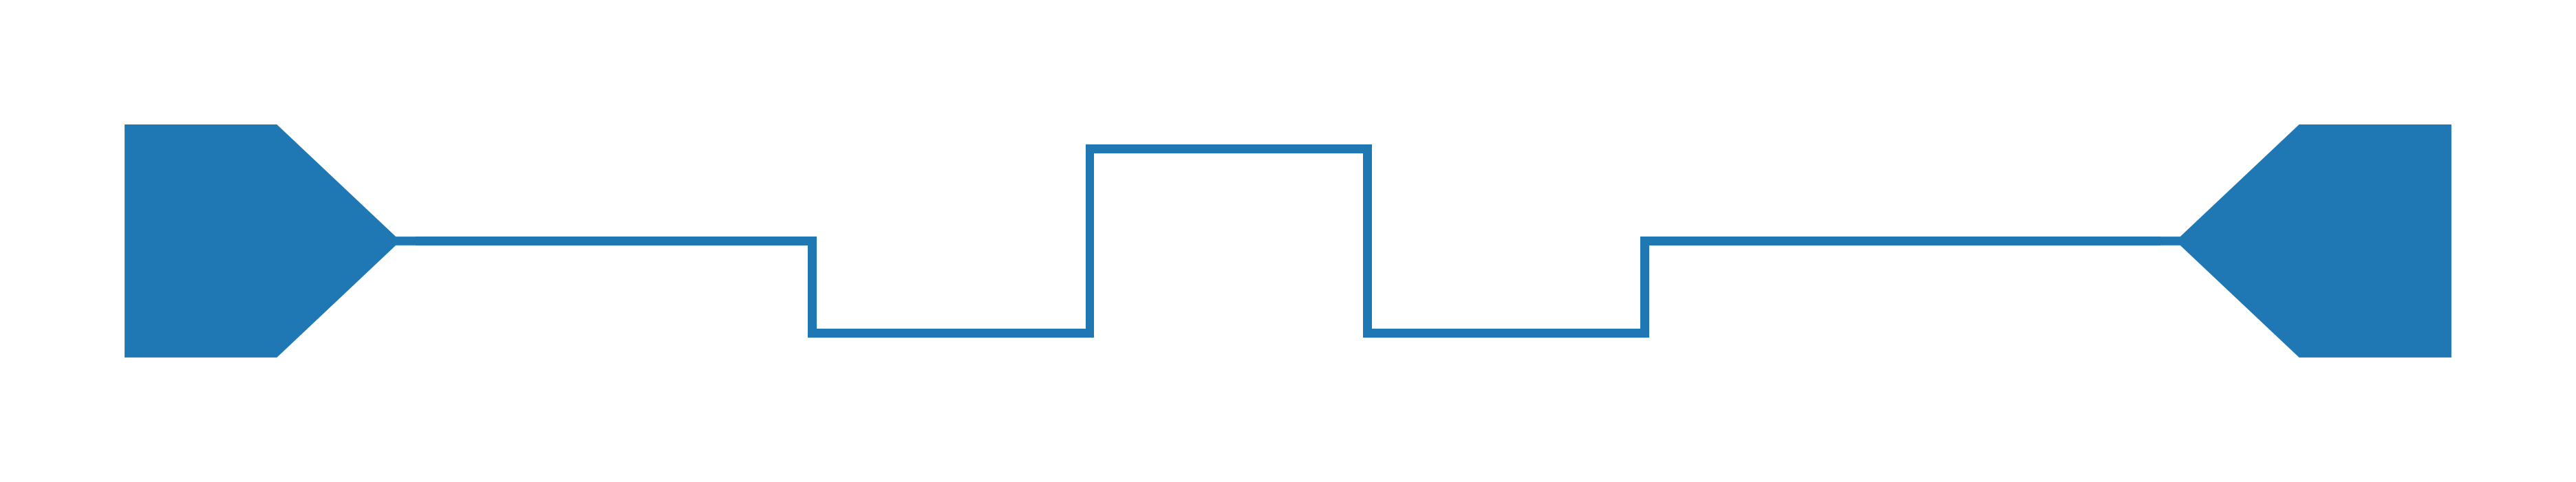

In [11]:
#@title 600-DPI preview (layer/datatype grouped)
import os, numpy as np, gdstk, matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from IPython.display import Image, display

# Locate most recent GDS if path changed
gds_path = str(GDS_PATH) if 'GDS_PATH' in globals() and os.path.isfile(GDS_PATH) else ""
if not gds_path:
    cands = []
    for root, _, files in os.walk("/content"):
        for f in files:
            if f.lower().endswith(".gds"):
                cands.append(os.path.join(root, f))
    gds_path = max(cands, key=os.path.getmtime)

lib = gdstk.read_gds(gds_path)
top = lib.top_level()[0]
flat = top.copy(name=f"{top.name}_FLAT"); flat.flatten()

by_spec = {}
for poly in flat.polygons:
    key = (poly.layer, poly.datatype)
    by_spec.setdefault(key, []).append(np.asarray(poly.points, dtype=float))

fig, ax = plt.subplots(figsize=(8,5), dpi=100)
for _, verts in by_spec.items():
    if verts:
        ax.add_collection(PolyCollection(verts, linewidth=0.4))  # default color cycle
(bb_min, bb_max) = flat.bounding_box()
xmin, ymin = bb_min; xmax, ymax = bb_max
pad = 0.05*max(xmax-xmin, ymax-ymin)
ax.set_xlim(xmin-pad, xmax+pad); ax.set_ylim(ymin-pad, ymax+pad)
ax.set_aspect("equal"); ax.axis("off")

png_out = os.path.splitext(gds_path)[0] + "_preview_600dpi.png"
pdf_out = os.path.splitext(gds_path)[0] + "_preview.pdf"
fig.savefig(png_out, dpi=600, bbox_inches="tight", pad_inches=0.02)
fig.savefig(pdf_out,        bbox_inches="tight", pad_inches=0.02)
plt.close(fig)

print("GDS:", gds_path)
print("Saved PNG:", png_out)
print("Saved PDF:", pdf_out)
display(Image(png_out))
